In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
train=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

# Let's explore movies dataset

In [3]:
movies.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


## Checking the features

In [4]:
no_of_features = len(movies.columns)
for i in range(no_of_features):
    print(f'{i+1} : {movies.columns[i]}')

1 : movieid
2 : title
3 : audienceScore
4 : rating
5 : ratingContents
6 : releaseDateTheaters
7 : releaseDateStreaming
8 : runtimeMinutes
9 : genre
10 : originalLanguage
11 : director
12 : boxOffice
13 : distributor
14 : soundType


### *****1. MovieID*****

In [5]:
movies.movieid.describe()

count                                          143258
unique                                         126404
top       escape_the_terminator_tyler_durden_astonish
freq                                              367
Name: movieid, dtype: object

In [6]:
movies.movieid.isna().sum()

0

## Takeaways

#### 1. (MovieID) There are no null values, but there are some duplicate values (unique < count), we need to handle them to merge this dataset with training and test dataset.

### ***2. Title***

In [7]:
movies.title.describe()

count                                          143258
unique                                         126404
top       Escape The Terminator Tyler Durden Astonish
freq                                              367
Name: title, dtype: object

In [8]:
movies.movieid.isna().sum()

0

## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column

### ***3. Audience Score***

In [9]:
movies.audienceScore.describe()

count    73248.000000
mean        55.674967
std         24.553648
min          0.000000
25%         37.000000
50%         57.000000
75%         76.000000
max        100.000000
Name: audienceScore, dtype: float64

In [10]:
# Ranges between 0 to 100, higher score, supports positive rating, might be an important feature.

In [11]:
movies.audienceScore.isna().sum()

70010

In [12]:
print(f'Around {(movies.audienceScore.isna().sum()/ movies.shape[0]*100 ).round(2)} % of this column is null')

Around 48.87 % of this column is null


## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column

#### 3. (AudienceScore) Since 49% data is nan, we can use ***regression imputation*** by other columns to predict its value and fill the missing data

### ***4. Rating***

In [13]:
movies.rating.describe()

count     13991
unique       10
top           R
freq       7734
Name: rating, dtype: object

In [14]:
movies.rating.isna().sum()

129267

In [15]:
movies.rating.value_counts()

R        7734
PG-13    3446
PG       1911
TVPG      424
TV14      397
TVMA       57
NC-17      19
TVG         1
TVY7        1
G           1
Name: rating, dtype: int64

In [16]:
print( f'Around {(movies.rating.isna().sum() / movies.shape[0]*100) .round(2)} % of this column is null')

Around 90.23 % of this column is null


## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column

#### 3. (AudienceScore) Since 49% data is nan, we can use ***regression imputation*** by other columns to predict its value and fill the missing data

#### 4. (Rating) Eventough rating has some contribution to the sentiment of the movie, 90 % of the column is null, so we might have to ***delete this column***.

### ***5. RatingContents***

In [17]:
movies.ratingContents.describe()

count            13991
unique            8353
top       ['Language']
freq               365
Name: ratingContents, dtype: object

In [18]:
movies.ratingContents.isna().sum()/ movies.shape[0]

0.90233704225942

## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column.

#### 3. (AudienceScore) Since 49% data is nan, we can use ***regression imputation*** by other columns to predict its value and fill the missing data.

#### 4. (Rating) Eventough rating has some contribution to the sentiment of the movie, 90 % of the column is null, so we might have to ***delete this column***.

#### 5. (RatingContents) Descibes the contents of the rating feature, 90* are null vales, so we can ***remove it***.

### ***6. releaseDateTheaters***

In [19]:
movies.releaseDateTheaters.describe()

count          30773
unique         12062
top       2018-09-14
freq              37
Name: releaseDateTheaters, dtype: object

In [20]:
(movies.releaseDateTheaters.isna().sum() / movies.shape[0] * 100).round(2)

78.52

## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column.

#### 3. (AudienceScore) Since 49% data is nan, we can use ***regression imputation*** by other columns to predict its value and fill the missing data.

#### 4. (Rating) Eventough rating has some contribution to the sentiment of the movie, 90 % of the column is null, so we might have to ***delete this column***.

#### 5. (RatingContents) Descibes the contents of the rating feature, 90* are null vales, so we can ***remove it***.

#### 6. (releaseDateTheatres) 79% are null and theatre doesn't matter to movie sentiment, so we can ***drop this column***.

### ***7. releaseDateStreaming***

In [21]:
movies.releaseDateStreaming.describe()

count          79420
unique          4726
top       2017-05-22
freq            1232
Name: releaseDateStreaming, dtype: object

In [22]:
movies.releaseDateStreaming.isna().sum() / movies.shape[0]

0.4456156026190509

In [23]:
#Date/ Period of release of a movie can determine a movie's sentiment, as people may like it in 
#some period and hate in different period

## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column.

#### 3. (AudienceScore) Since 49% data is nan, we can use ***regression imputation*** by other columns to predict its value and fill the missing data.

#### 4. (Rating) Eventough rating has some contribution to the sentiment of the movie, 90 % of the column is null, so we might have to ***delete this column***.

#### 5. (RatingContents) Descibes the contents of the rating feature, 90* are null vales, so we can ***remove it***.

#### 6. (releaseDateTheatres) 79% are null and theatre doesn't matter to movie sentiment, so we can ***drop this column***.

#### 7. (releaseDateStreaming) ***Impute missing dates*** and ***convert them to integer***.

### ***8. runtimeMinutes***

In [24]:
movies.runtimeMinutes.describe()

count    129431.000000
mean         93.708578
std          28.129175
min           1.000000
25%          84.000000
50%          92.000000
75%         103.000000
max        2700.000000
Name: runtimeMinutes, dtype: float64

In [25]:
#The runTimeMinutes ranges from 1 min to 2700 mins, with a mean of 93. Need to handle outliers

In [26]:
movies.runtimeMinutes.isna().sum() / movies.shape[0]

0.09651817001493808

## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column.

#### 3. (AudienceScore) Since 49% data is nan, we can use ***regression imputation*** by other columns to predict its value and fill the missing data.

#### 4. (Rating) Eventough rating has some contribution to the sentiment of the movie, 90 % of the column is null, so we might have to ***delete this column***.

#### 5. (RatingContents) Descibes the contents of the rating feature, 90* are null vales, so we can ***remove it***.

#### 6. (releaseDateTheatres) 79% are null and theatre doesn't matter to movie sentiment, so we can ***drop this column***.

#### 7. (releaseDateStreaming) ***Impute missing dates*** and ***convert them to integer***.

#### 8. (runtimeMinutes) We need to ***handle missing values*** and also ***handle outliers***.

### ***9. Genre***

In [27]:
movies.genre.describe()

count     132175
unique      2912
top        Drama
freq       27860
Name: genre, dtype: object

In [28]:
movies.genre.value_counts()

Drama                                          27860
Documentary                                    15162
Comedy                                         11514
Mystery & thriller                              7015
Comedy, Drama                                   5479
                                               ...  
Fantasy, Drama, Musical                            1
Holiday, Drama, Musical                            1
Drama, War, Adventure, Action                      1
Action, Adventure, Comedy, Drama, Animation        1
Western, Comedy, Animation                         1
Name: genre, Length: 2912, dtype: int64

In [29]:
movies.genre.isna().sum() / movies.shape[0]

0.0773639168493208

## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column.

#### 3. (AudienceScore) Since 49% data is nan, we can use ***regression imputation*** by other columns to predict its value and fill the missing data.

#### 4. (Rating) Eventough rating has some contribution to the sentiment of the movie, 90 % of the column is null, so we might have to ***delete this column***.

#### 5. (RatingContents) Descibes the contents of the rating feature, 90* are null vales, so we can ***remove it***.

#### 6. (releaseDateTheatres) 79% are null and theatre doesn't matter to movie sentiment, so we can ***drop this column***.

#### 7. (releaseDateStreaming) ***Impute missing dates*** and ***convert them to integer***.

#### 8. (runtimeMinutes) We need to ***handle missing values*** and also ***handle outliers***.

#### 9. (Genre) First, we need to ***handle Missing Values*** and then ***use some encoder*** to change categorical feature into numbers.

### ***10. originalLanguage***

In [30]:
movies.originalLanguage.describe()

count      129400
unique        112
top       English
freq        85034
Name: originalLanguage, dtype: object

In [31]:
movies.originalLanguage.isna().sum()

13858

In [32]:
duplicates_mask = movies['movieid'].duplicated(keep=False)
duplicate_movies = movies[duplicates_mask]

## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column.

#### 3. (AudienceScore) Since 49% data is nan, we can use ***regression imputation*** by other columns to predict its value and fill the missing data.

#### 4. (Rating) Eventough rating has some contribution to the sentiment of the movie, 90 % of the column is null, so we might have to ***delete this column***.

#### 5. (RatingContents) Descibes the contents of the rating feature, 90* are null vales, so we can ***remove it***.

#### 6. (releaseDateTheatres) 79% are null and theatre doesn't matter to movie sentiment, so we can ***drop this column***.

#### 7. (releaseDateStreaming) ***Impute missing dates*** and ***convert them to integer***.

#### 8. (runtimeMinutes) We need to ***handle missing values*** and also ***handle outliers***.

#### 9. (Genre) First, we need to ***handle Missing Values*** and then ***use some encoder*** to change categorical feature into numbers.

#### 10. (originalLanguage), handle missing values and encode them.

In [33]:
movies.columns

Index(['movieid', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType'],
      dtype='object')

## Takeaways

#### 1. (MovieID) There are no null values, but there are ***some duplicate values*** (unique < count), we need to handle them to merge this dataset with training and test dataset.

#### 2. (Title) Each movieID has unique title, because their statistics are same, we can ***remove this feature***, as it doesn't contribute to the rating of a movie, and movieID can be used as a proxy for this column.

#### 3. (AudienceScore) Since 49% data is nan, we can use ***regression imputation*** by other columns to predict its value and fill the missing data.

#### 4. (Rating) Eventough rating has some contribution to the sentiment of the movie, 90 % of the column is null, so we might have to ***delete this column***.

#### 5. (RatingContents) Descibes the contents of the rating feature, 90* are null vales, so we can ***remove it***.

#### 6. (releaseDateTheatres) 79% are null and theatre doesn't matter to movie sentiment, so we can ***drop this column***.

#### 7. (releaseDateStreaming) ***Impute missing dates*** and ***convert them to integer***.

#### 8. (runtimeMinutes) We need to ***handle missing values*** and also ***handle outliers***.

#### 9. (Genre) First, we need to ***handle Missing Values*** and then ***use some encoder*** to change categorical feature into numbers.

#### 10. (originalLanguage), handle missing values and encode them.

#### 11. Remove 'director', 'boxOffice', 'distributor','soundType' as they are not important

In [34]:
# takeaway 1
movies.drop_duplicates(subset='movieid', inplace=True)

In [35]:
# takeaway 2
movies.drop('title', axis=1, inplace=True)

In [36]:
# takeaway 3, will deal later


In [37]:
# takeaway 4
movies.drop('rating', axis=1, inplace=True)

In [38]:
# takeaway 5
movies.drop('ratingContents', axis=1, inplace=True)

In [39]:
# takeaway 6
movies.drop('releaseDateTheaters', axis=1, inplace=True)

In [40]:
# takeaway 7
movies['releaseDateStreaming'] = pd.to_datetime(movies['releaseDateStreaming'])

mean_date = movies['releaseDateStreaming'].mean()  # Calculate the mean date
min_date = movies['releaseDateStreaming'].min()

movies['releaseDateStreaming'].fillna(mean_date, inplace=True)  # Fill missing dates with mean date
movies['releaseDateStreaming'] = movies['releaseDateStreaming'].apply(lambda x: (x - min_date).days if pd.notnull(x) else None)


In [41]:
# takeaway 8
mean_runtime = movies['runtimeMinutes'].mean()
Q1 = movies['runtimeMinutes'].quantile(0.25)
Q3 = movies['runtimeMinutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
movies['runtimeMinutes'] = movies['runtimeMinutes'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)


movies['runtimeMinutes'].fillna(mean_runtime, inplace=True)

In [42]:
# takeaway 9
from  sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
movies['genre'] = label_encoder.fit_transform(movies['genre'].fillna('Unknown'))

In [43]:
# takeaway 10
label_encoder = LabelEncoder()
movies['originalLanguage'] = label_encoder.fit_transform(movies['originalLanguage'].fillna('Unknown'))

In [44]:
# takeaway 11
movies.drop(['director', 'boxOffice', 'distributor','soundType'], axis=1, inplace=True)

In [45]:
#takeaeway 3
from sklearn.linear_model import LinearRegression
movies_regression=movies[['audienceScore','releaseDateStreaming','runtimeMinutes','genre','originalLanguage']]
train_data = movies_regression[movies['audienceScore'].notnull()]
predict_data = movies_regression[movies['audienceScore'].isnull()]
X_audience_train = train_data.drop('audienceScore', axis=1)  # Drop the original 'audienceScore' column
y_audience_train = train_data['audienceScore']  # Target variable - 'audienceScore'
regressor = LinearRegression()
regressor.fit(X_audience_train, y_audience_train)

LinearRegression()

In [46]:
X_audience_predict = predict_data.drop('audienceScore', axis=1)
imputed_scores = regressor.predict(X_audience_predict)


movies.loc[movies['audienceScore'].isnull(), 'audienceScore'] = imputed_scores

In [47]:
movies

,movieid,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage
0,han_solo_heroic_myth_wonder_woman,50.000000,32757,75.0,888,22
1,voyage_tyler_durden_han_solo_stardust,59.394743,33292,114.0,1248,22
2,norman_bates_ferris_bueller_hermione_granger_v...,43.000000,31267,120.0,1248,51
3,elegant_hermione_granger,60.000000,33547,90.0,322,22
4,adventure_rocky_balboa,70.000000,32241,80.0,1530,22
...,...,...,...,...,...,...
143252,james_bond_jason_bourne,69.287541,32888,131.0,322,39
143253,sherlock_holmes_surreal_james_bond,14.000000,31267,90.0,8,47
143254,mr._miyagi_katniss_everdeen_harmony,55.488562,31267,99.0,1248,22
143255,elegant_emerald_valiant_donnie_darko,71.000000,31267,53.0,1041,22


# Now we will merge movies and train data

In [48]:
data = pd.merge(train, movies, on='movieid', how='left')

In [49]:
data

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,65.000000,34282,105.0,738,22
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,58.137082,30702,91.0,0,22
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,80.000000,32928,130.0,1248,22
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,54.610161,33404,53.0,1248,87
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE,97.000000,27566,131.0,981,75
...,...,...,...,...,...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top-notch thriller with genuine surprises an...,POSITIVE,49.628891,27412,96.0,2447,22
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE,20.000000,31934,102.0,722,22
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE,78.000000,34149,90.0,768,22
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE,39.000000,25522,88.0,2155,22


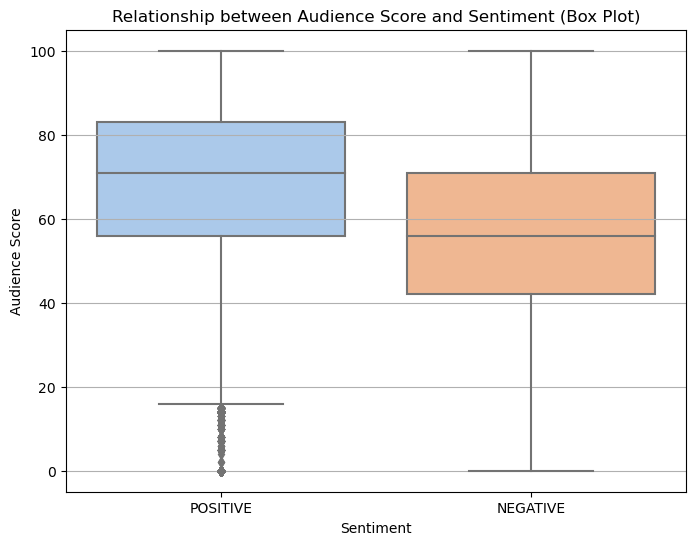

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='audienceScore', data=data, palette='pastel')
plt.xlabel('Sentiment')
plt.ylabel('Audience Score')
plt.title('Relationship between Audience Score and Sentiment (Box Plot)')
plt.grid(axis='y')
plt.show()

In [51]:
# We can infer that median of positive points is higher than that of negative points, altough positive have some outliers

In [52]:
# we will remove movieid reviewerName as they are not required
data.drop(['movieid', 'reviewerName'], axis=1, inplace=True)

In [53]:
data

,isFrequentReviewer,reviewText,sentiment,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage
0,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,65.000000,34282,105.0,738,22
1,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,58.137082,30702,91.0,0,22
2,True,Creed II does not give us anything but another...,POSITIVE,80.000000,32928,130.0,1248,22
3,False,"I know what you're thinking, but this is no Li...",POSITIVE,54.610161,33404,53.0,1248,87
4,False,Director Fernando Meirelles tells the story wi...,POSITIVE,97.000000,27566,131.0,981,75
...,...,...,...,...,...,...,...,...
162753,False,A top-notch thriller with genuine surprises an...,POSITIVE,49.628891,27412,96.0,2447,22
162754,True,Some people find Derek Zoolander funny and lik...,NEGATIVE,20.000000,31934,102.0,722,22
162755,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE,78.000000,34149,90.0,768,22
162756,False,"The film is rescued by a strong third act, but...",NEGATIVE,39.000000,25522,88.0,2155,22


In [54]:
le=LabelEncoder()
data['isFrequentReviewer'] = le.fit_transform(data['isFrequentReviewer'].fillna('Unknown'))

# Vectorize ReviewText

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [56]:
data.reviewText = data.reviewText.fillna('')

In [57]:
tfidf = TfidfVectorizer()
X= tfidf.fit_transform(data["reviewText"])

In [58]:
from scipy.sparse import hstack, csr_matrix

In [59]:
data = data.drop('reviewText',axis=1)

In [60]:
y_train = data['sentiment']
data.drop('sentiment',axis=1,inplace=True)

In [61]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
data=ss.fit_transform(data)

In [62]:
data= hstack([X, csr_matrix(data)])

In [63]:
print(data)

  (0, 35617)	0.2567860162736015
  (0, 37971)	0.27523784812123053
  (0, 55346)	0.2663843537779286
  (0, 21304)	0.3429404578205858
  (0, 26941)	0.15046571295948769
  (0, 12455)	0.38736809237428155
  (0, 307)	0.3526713988257433
  (0, 52537)	0.23294976315778151
  (0, 38084)	0.12526409274454592
  (0, 21551)	0.18760851986423108
  (0, 51163)	0.4071473547222177
  (0, 26583)	0.3189711455209067
  (0, 65220)	-0.661763740118849
  (0, 65221)	0.028225473615889753
  (0, 65222)	1.6190855518522282
  (0, 65223)	-0.0068777096530509615
  (0, 65224)	-0.8556163483193389
  (0, 65225)	-0.3125496379578653
  (1, 50513)	0.2823248171190743
  (1, 27149)	0.1850669203537821
  (1, 54838)	0.22719976039266876
  (1, 40303)	0.05758389764613271
  (1, 29510)	0.19370854892459097
  (1, 10286)	0.18500211222597396
  (1, 37254)	0.21963458177665265
  :	:
  (162756, 1134)	0.3154937033555598
  (162756, 55606)	0.2894795876205392
  (162756, 57974)	0.2017499901905095
  (162756, 21369)	0.14468239166426308
  (162756, 8245)	0.1826354469

In [64]:
y_train =y_train.map({'POSITIVE': 1, 'NEGATIVE': -1})

In [65]:
y_train

0         1
1        -1
2         1
3         1
4         1
         ..
162753    1
162754   -1
162755    1
162756   -1
162757    1
Name: sentiment, Length: 162758, dtype: int64

# Model Training

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [67]:
logreg = LogisticRegression(max_iter=1000,solver='liblinear')
param_grid = {
    'C': [ 0.1, 1, 10],
    'penalty':['l1','l2']
}
grid_search_log = GridSearchCV(logreg, param_grid, cv=5)
grid_search_log.fit(data, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']})

In [68]:
grid_search_log.score(data,y_train)

0.8463547106747441

In [69]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    'max_depth': [ 5, 10],              
    'min_samples_split': [2, 5, 10]            
}
dt_classifier = DecisionTreeClassifier()
grid_search_dt = GridSearchCV(dt_classifier, param_grid, cv=5)
grid_search_dt.fit(data, y_train)
grid_search_dt.score(data,y_train)

0.7288182454933091

In [70]:
import xgboost as xgb

grid_search_xg = xgb.XGBClassifier()
grid_search_xg.fit(data, (y_train+1)/2)
grid_search_xg.score(data,(y_train+1)/2)

0.7982833409110458

In [71]:
from sklearn.metrics import confusion_matrix

y_train_pred = grid_search_log.predict(data)

cm = confusion_matrix(y_train,y_train_pred )

print(cm)

[[ 36863  17134]
 [  7873 100888]]


In [72]:
from sklearn.metrics import precision_score, recall_score

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.8548236769415871
Recall: 0.927611919713868


# Plotting ROC curve

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [74]:
y_probs = grid_search_log.predict_proba(data)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_probs)
roc_auc = roc_auc_score(y_train, y_probs)

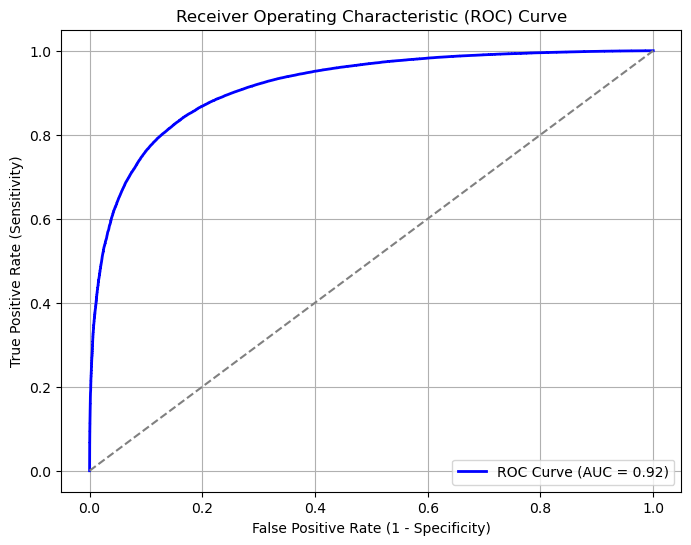

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [76]:
test_data = pd.merge(test, movies, on='movieid', how='left')

In [77]:
test_data.drop(['movieid', 'reviewerName'], axis=1, inplace=True)

In [78]:
test_data

,isTopCritic,reviewText,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage
0,False,Green slowly cranks up the dread with style an...,57.000000,34268,111.00000,1779,22
1,False,Philip Noyce's direction is elegant and unforc...,86.000000,27146,94.00000,1271,22
2,False,It wouldn't do to say what path Maria ultimate...,62.000000,31267,93.57045,1248,29
3,False,Pig is not exactly the arthouse John Wick that...,84.000000,33831,92.00000,1421,22
4,False,An imaginative no-budget musical of sorts abou...,44.297597,31267,66.00000,1408,3
...,...,...,...,...,...,...,...
55310,False,Ron Howard delivers an unconventional romantic...,29.000000,30086,111.00000,700,22
55311,False,As an oddball art film that openly invites you...,71.000000,30744,116.00000,786,22
55312,False,Nicholson wears his devilish grin from his fir...,60.000000,27300,106.00000,700,22
55313,True,It's hard not be entertained by two dozen of C...,65.000000,27762,125.00000,2284,22


In [79]:
test_data['isTopCritic'] = le.fit_transform(test_data['isTopCritic'].fillna('Unknown'))

In [80]:
test_data.reviewText = test_data.reviewText.fillna('')

In [81]:
Y= tfidf.transform(test_data["reviewText"])

In [82]:
test_data = test_data.drop('reviewText', axis=1)

In [83]:
test_data.rename(columns={'isTopCritic': 'isFrequentReviewer'}, inplace=True)


In [84]:
test_data=ss.transform(test_data)

In [85]:
test_data= hstack([Y, csr_matrix(test_data)])

## Logistic regression has the best accuracy among the 3 models compared.

In [86]:
y_pred = grid_search_log.predict(test_data)

In [87]:
y_pred

array([ 1,  1,  1, ..., -1,  1, -1])

In [88]:
submission = pd.DataFrame(columns=['id','sentiment'])
submission['id']=[ i for i in range(test.shape[0])]
submission['sentiment']=y_pred

In [89]:
submission['sentiment'] = submission['sentiment'].replace({1: "POSITIVE", -1: "NEGATIVE"})


In [90]:
submission.to_csv('submission.csv',index=False)


In [91]:
submission.sentiment.value_counts()

POSITIVE    40417
NEGATIVE    14898
Name: sentiment, dtype: int64